In [1]:
import uproot
import numpy as np
import awkward as ak
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
# Load signal sample into memory
with uproot.open("../pythia/output/dataset_diHiggs_mu60_NumEvents10k_MinJetpT25.root:fastjet") as f:
    jet_pt_sig = f["jet_pt"].array()
    jet_eta_sig = f["jet_eta"].array()
    jet_phi_sig = f["jet_phi"].array()
    jet_m_sig = f["jet_m"].array()
    jet_pufr_sig = f["jet_pufr_truth"].array()
    jet_label_sig = ak.ones_like(jet_pt_sig)

# Load background sample into memory
with uproot.open("../pythia/output/dataset_4b_FILTER60_mu60_NumEvents10k_MinJetpT25.root:fastjet") as f:
    jet_pt_bkg = f["jet_pt"].array()
    jet_eta_bkg = f["jet_eta"].array()
    jet_phi_bkg = f["jet_phi"].array()
    jet_m_bkg = f["jet_m"].array()
    jet_pufr_bkg = f["jet_pufr_truth"].array()
    jet_label_bkg = ak.zeros_like(jet_pt_bkg)

In [3]:
class Jet:
    """
    The Jet object contains the features of each jet at the event level.
    It also has many useful methods to assist with data processing.
    """
    def __init__(self, feats):
        pt, eta, phi, m, pufr, label = feats
        self.pt = pt
        self.eta = eta
        self.phi = phi
        self.m = m
        self.pufr = pufr
        self.label = label

    def __len__(self):
        return len(self.pt)
        
    def apply_mask(self, mask):
        self.pt = self.pt[mask]
        self.eta = self.eta[mask]
        self.phi = self.phi[mask]
        self.m = self.m[mask]
        self.pufr = self.pufr[mask]
        self.label = self.label[mask]
        
    def return_event_idx(self):
        sig = (self.label==1)
        sig_event = ak.mean(sig,axis=1)==1
        bkg_event = ak.mean(sig,axis=1)==0
        return sig_event,bkg_event

    def return_mean(self):
        return [ak.mean(self.pt), ak.mean(self.eta), ak.mean(self.phi), ak.mean(self.m)]
    
    def return_std(self):
        return [ak.std(self.pt), ak.std(self.eta), ak.std(self.phi), ak.std(self.m)]
    
    def apply_norm(self,mean_list,std_list):
        self.pt = (self.pt-mean_list[0]) / std_list[0]
        self.eta = (self.eta-mean_list[1]) / std_list[1]
        self.phi = (self.phi-mean_list[2]) / std_list[2]
        self.m = (self.m-mean_list[3]) / std_list[3]
        
    def return_subset(self, start_idx, stop_idx):
        pt = self.pt[start_idx:stop_idx]
        eta = self.eta[start_idx:stop_idx]
        phi = self.phi[start_idx:stop_idx]
        m = self.m[start_idx:stop_idx]
        pufr = self.pufr[start_idx:stop_idx]
        label = self.label[start_idx:stop_idx]
        feats = [pt,eta,phi,m,pufr,label]
        return Jet(feats)
    
    def return_dataset(self, feat_names):
        feats = {'pt': self.pt, 'eta': self.eta, 'phi': self.phi, 'm': self.m, 'pufr': self.pufr}
        feat_list = []
        for feat in feat_names:
            feat_list.append(feats[feat][:,:,np.newaxis])
        data = ak.concatenate(feat_list, axis=2)
        labels = ak.mean(self.label,axis=1)
        return data, labels

In [4]:
# Construct list of features
feats_sig = [jet_pt_sig, jet_eta_sig, jet_phi_sig, jet_m_sig, jet_pufr_sig, jet_label_sig]
feats_bkg = [jet_pt_bkg, jet_eta_bkg, jet_phi_bkg, jet_m_bkg, jet_pufr_bkg, jet_label_bkg]

# Combined Signal and Background
feats = []
for i in range(len(feats_sig)):
    feats.append(ak.concatenate([feats_sig[i],feats_bkg[i]], axis=0))
    
# Initialize Jet object and pass features
jets = Jet(feats)

# Print features
print(jets.pt)
print(jets.eta)
print(jets.phi)
print(jets.m)
print(jets.pufr)
print(jets.label)

[[161, 155, 137, 135, 86.2, 71.7, ..., 25.7, 25.5, 25.4, 25.1, 25.1, 25], ...]
[[1.38, 0.786, -2.29, 0.337, 2.15, ..., 5.3, -5.68, -3.76, 4.07, -5.41], ...]
[[2.85, 5.01, 1.86, 5.95, 0.982, 1.95, ..., 1.22, 4.77, 1.15, 5.95, 2.11], ...]
[[52.6, 35.3, 62.2, 50.4, 33.3, 32.5, ..., 17.9, 17.3, 17.8, 14, 12.9], ...]
[[0.0226, 0.0263, 0.048, 0.236, 0.133, 0.992, ..., 0.929, 1, 1, 0.594, 1], ...]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], ...]


In [5]:
# Shuffle the events
shuffled_idx = np.random.permutation(len(jets))
jets.apply_mask(shuffled_idx)

In [6]:
# Plot number of jets per event
h_num_jets = ak.num(jets.pt,axis=1)
sig,bkg = jets.return_event_idx()
#plt.title('Num Jets per Event')
#plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=30,range=(0,ak.max(h_num_jets)))
#plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=30,range=(0,ak.max(h_num_jets)))
#plt.xlabel('Num Jets',loc='right')
#plt.legend()
#plt.show()

# Require at least 4 jets
mask = h_num_jets>=4
jets.apply_mask(mask)
h_num_jets = ak.num(jets.pt,axis=1)
sig,bkg = jets.return_event_idx()
#plt.title('Num Jets per Event (Require 6 Jets)')
#plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=30,range=(0,ak.max(h_num_jets)))
#plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=30,range=(0,ak.max(h_num_jets)))
#plt.xlabel('Num Jets',loc='right')
#plt.legend()
#plt.show()

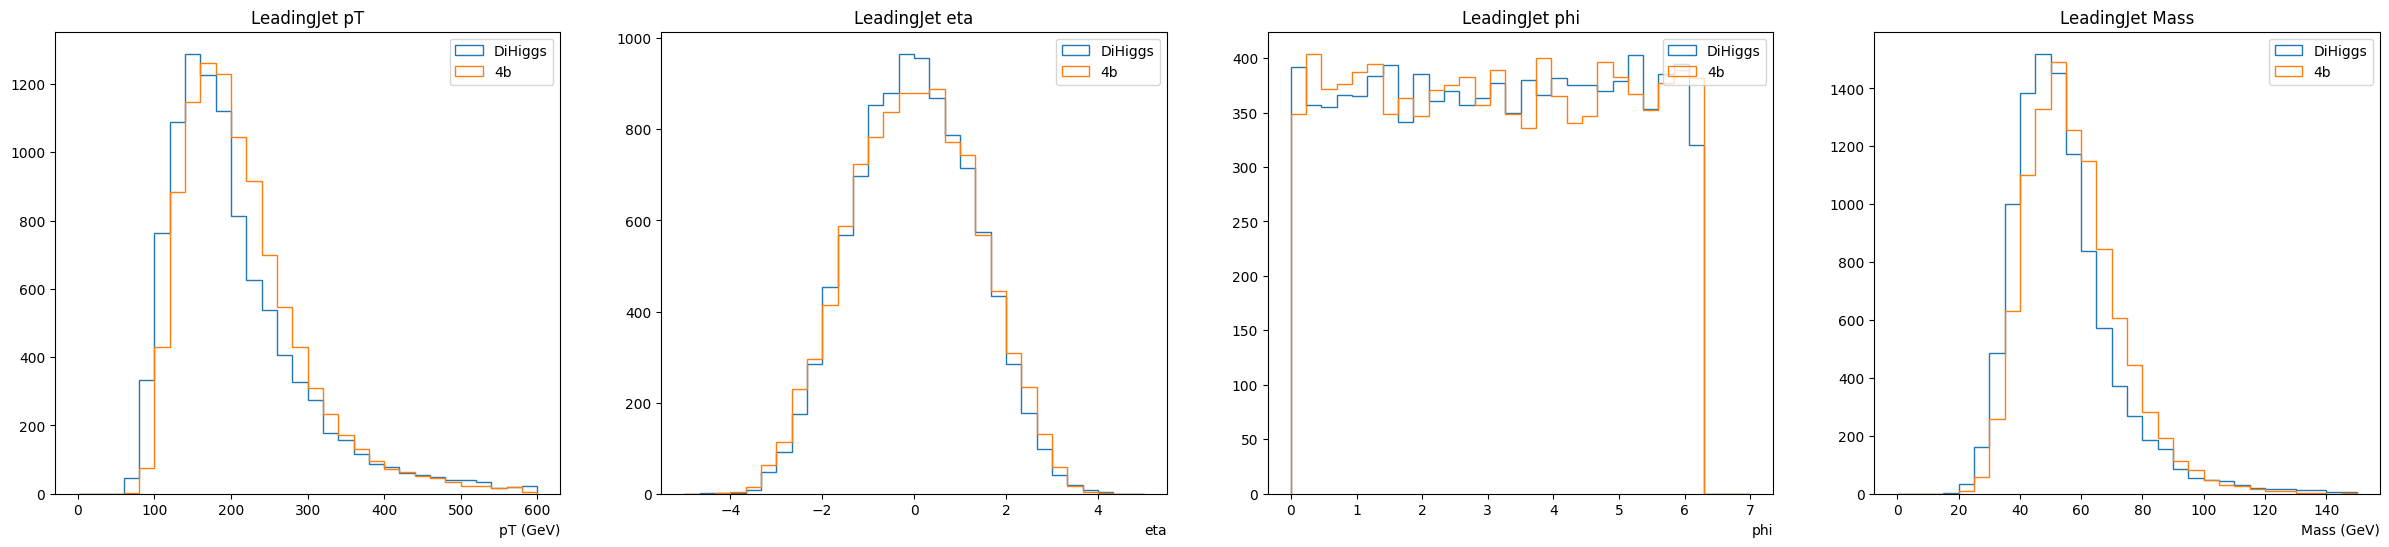

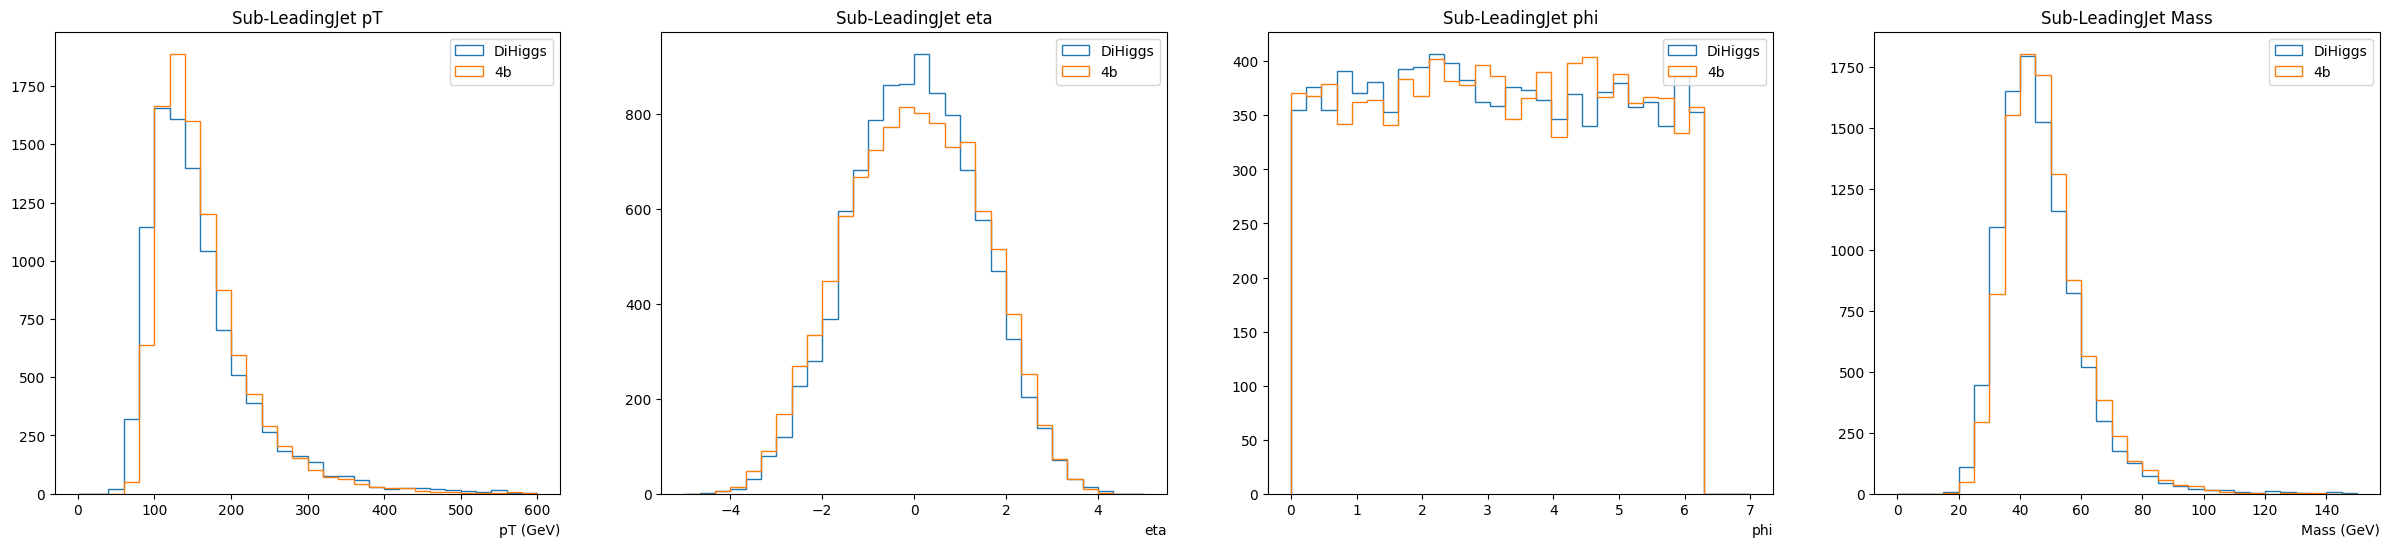

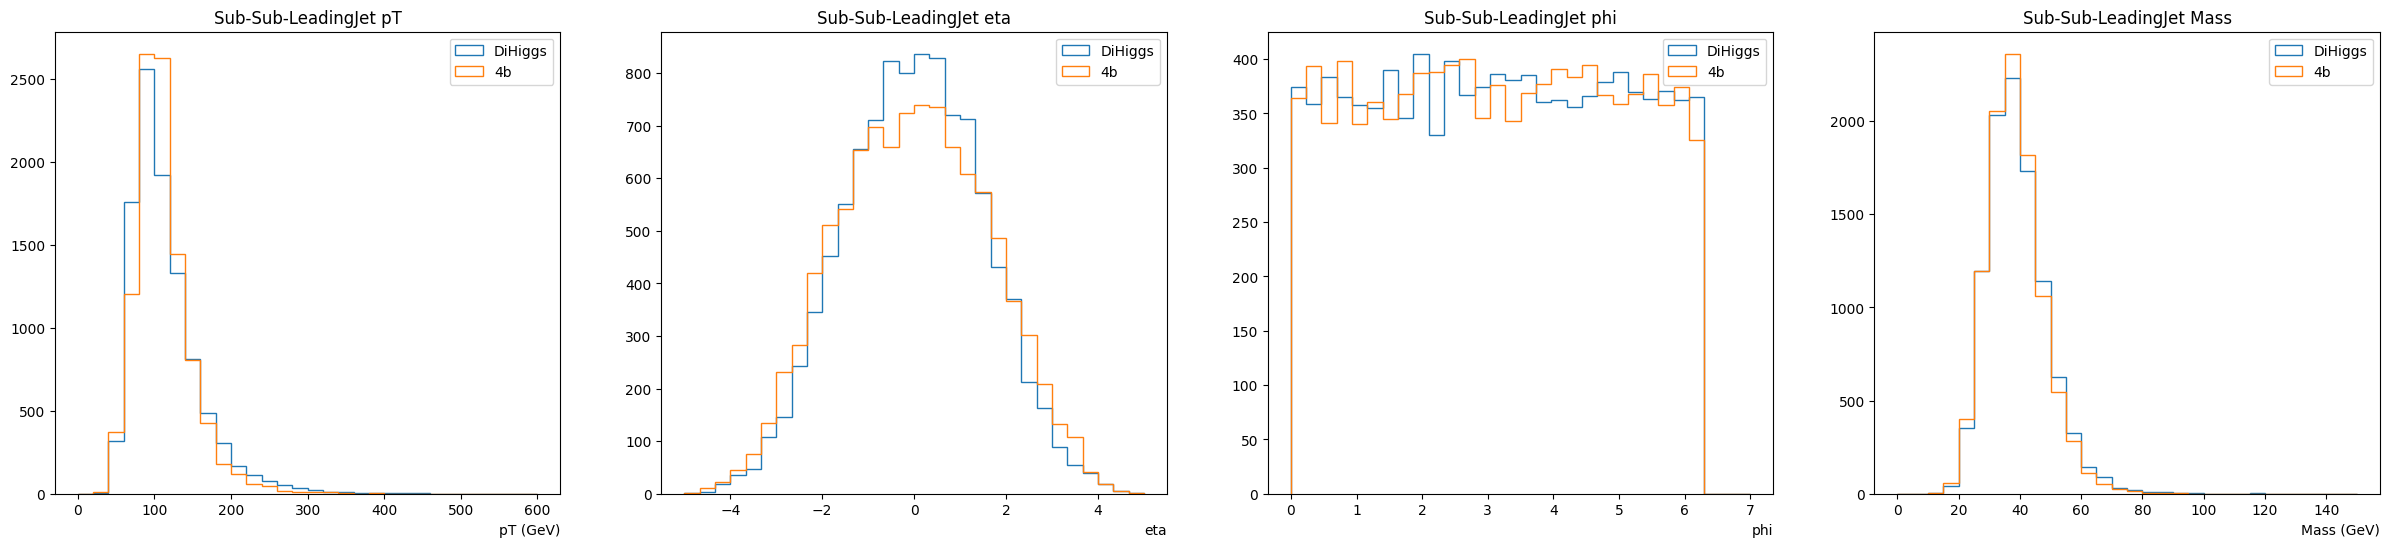

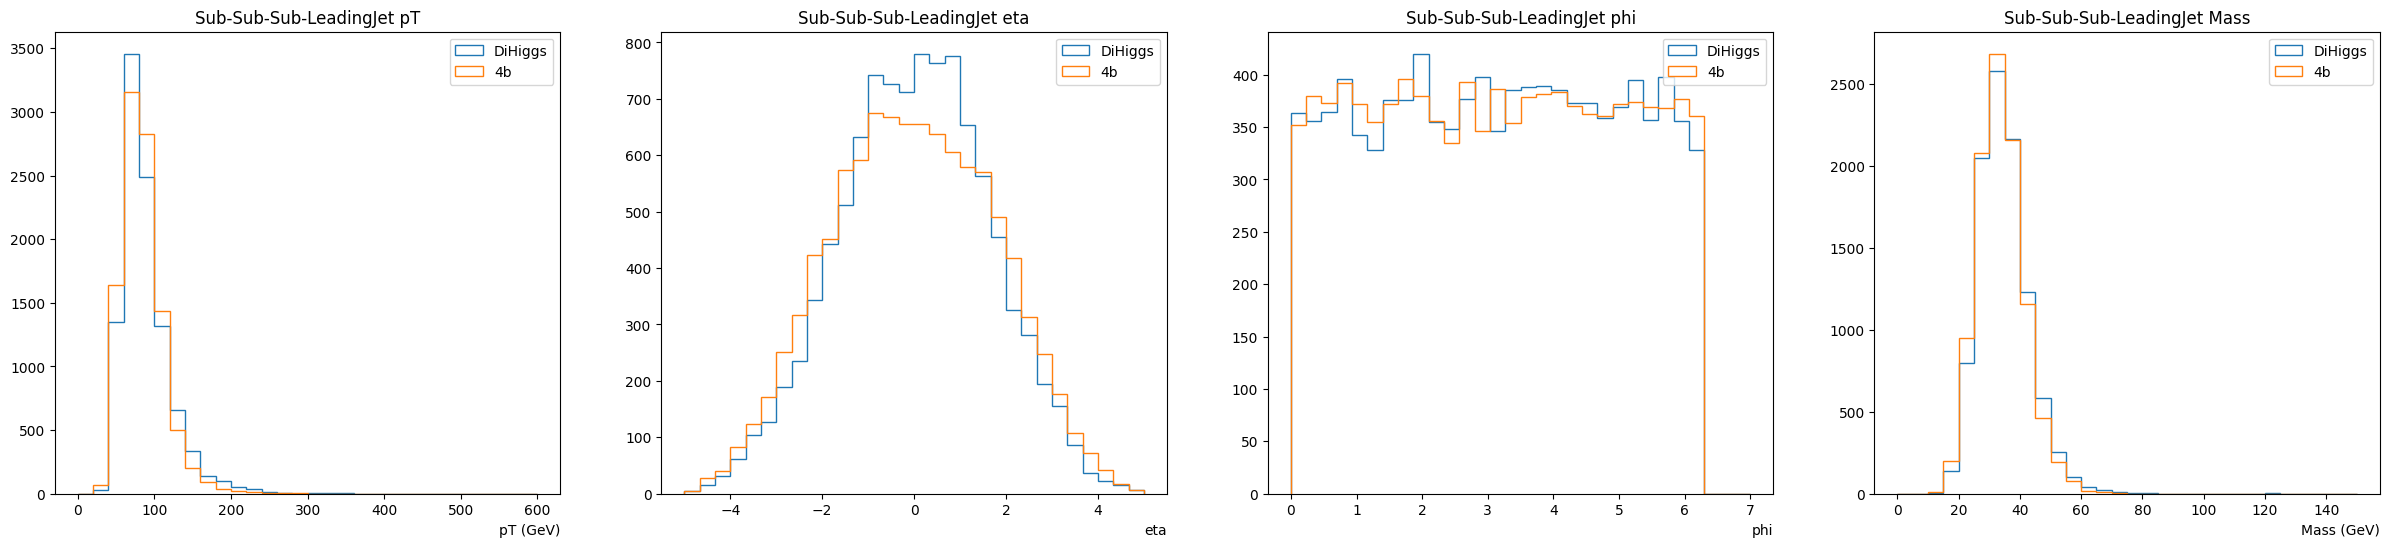

In [7]:
sig,bkg = jets.return_event_idx()
var_list = ['Leading','Sub-Leading','Sub-Sub-Leading','Sub-Sub-Sub-Leading']
for i, name in enumerate(var_list):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 6))

    ax1.set_title(name+'Jet pT')
    ax1.hist(jets.pt[:,i][sig],histtype='step',label='DiHiggs',bins=30,range=(0,600))
    ax1.hist(jets.pt[:,i][bkg],histtype='step',label='4b',bins=30,range=(0,600))
    ax1.set_xlabel('pT (GeV)',loc='right')
    ax1.legend(loc='upper right')

    ax2.set_title(name+'Jet eta')
    ax2.hist(jets.eta[:,i][sig],histtype='step',label='DiHiggs',bins=30,range=(-5,5))
    ax2.hist(jets.eta[:,i][bkg],histtype='step',label='4b',bins=30,range=(-5,5))
    ax2.set_xlabel('eta',loc='right')
    ax2.legend(loc='upper right')


    ax3.set_title(name+'Jet phi')
    ax3.hist(jets.phi[:,i][sig],histtype='step',label='DiHiggs',bins=30,range=(0,7))
    ax3.hist(jets.phi[:,i][bkg],histtype='step',label='4b',bins=30,range=(0,7))
    ax3.set_xlabel('phi',loc='right')
    ax3.legend(loc='upper right')

    ax4.set_title(name+'Jet Mass')
    ax4.hist(jets.m[:,i][sig],histtype='step',label='DiHiggs',bins=30,range=(0,150))
    ax4.hist(jets.m[:,i][bkg],histtype='step',label='4b',bins=30,range=(0,150))
    ax4.set_xlabel('Mass (GeV)',loc='right')
    ax4.legend(loc='upper right')
    plt.show()

In [8]:
def test_val_train_split(Jets):
    num_events = len(Jets)
    train_split = int(0.7*num_events)
    test_split = int(0.75*num_events)
    
    X_train = Jets.return_subset(0,train_split)
    X_val = Jets.return_subset(train_split,test_split)
    X_test = Jets.return_subset(test_split,num_events)
    
    mean_list = X_train.return_mean()
    std_list = X_train.return_std()
    
    X_train.apply_norm(mean_list, std_list)
    X_val.apply_norm(mean_list, std_list)
    X_test.apply_norm(mean_list, std_list)
    
    X_train, y_train = X_train.return_dataset(['pt','eta','phi','m','pufr'])
    X_val, y_val = X_val.return_dataset(['pt','eta','phi','m','pufr'])
    X_test, y_test = X_test.return_dataset(['pt','eta','phi','m','pufr'])
    
    return X_train, y_train, X_val, y_val, X_test, y_test
    
X_train, y_train, X_val, y_val, X_test, y_test = test_val_train_split(jets)

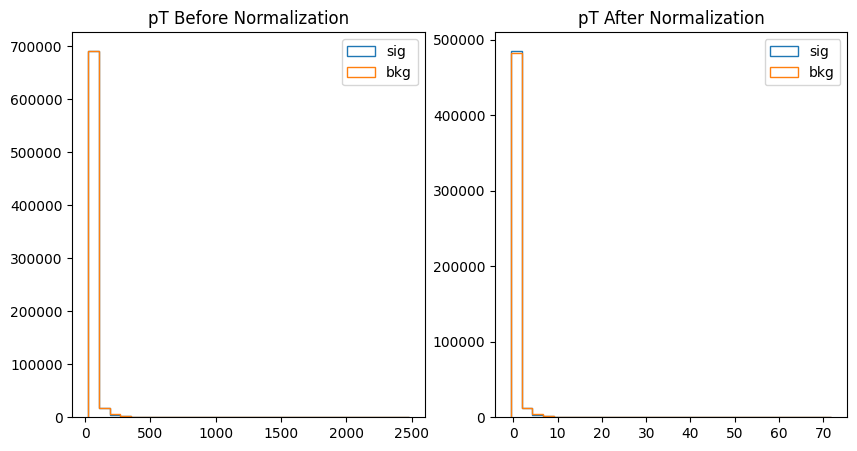

Before Mean:  42.19674448164315
Before STD:  34.030986043323395
After Mean:  -0.00018457113730977056
After STD:  0.9997567616209745


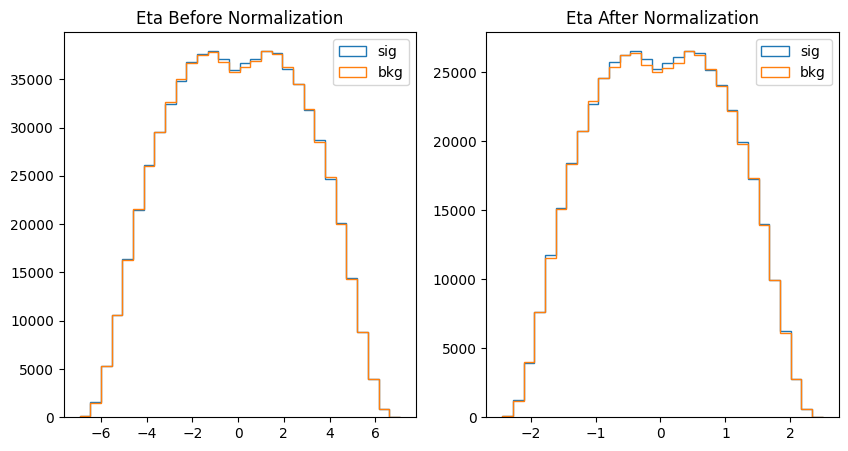

Before Mean:  0.001214536008511282
Before STD:  2.8301830570923245
After Mean:  3.70287144527363e-12
After STD:  1.0001638993131658


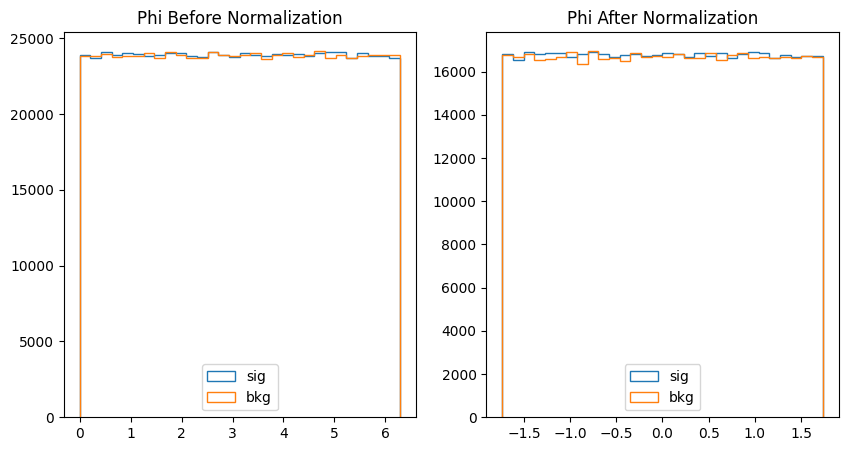

Before Mean:  3.1407384179210474
Before STD:  1.8115096138129871
After Mean:  8.05245296311064e-05
After STD:  1.0006517101152494


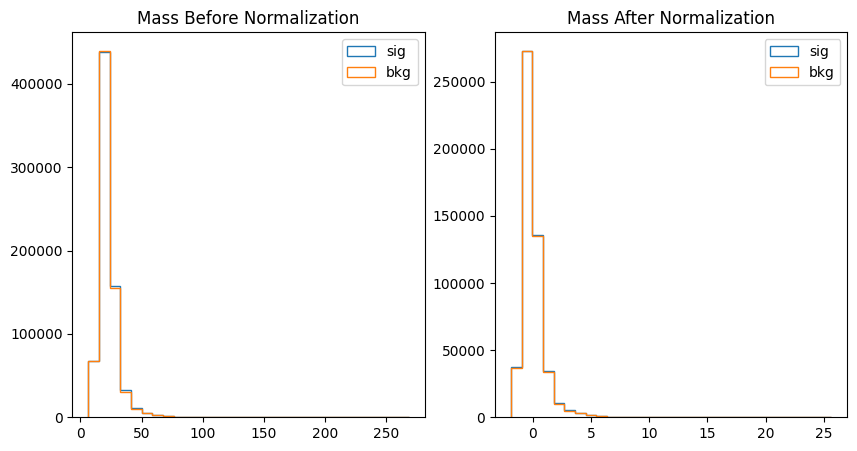

Before Mean:  22.37552801192653
Before STD:  8.22714895061827
After Mean:  5.632945598108656e-05
After STD:  0.9999518005670089


In [9]:
# Validation plots
var_list = ['pT','Eta','Phi','Mass']
var_list_before = [jets.pt,jets.eta,jets.phi,jets.m,jets.pufr]
var_list_after = [X_train[:,:,0],X_train[:,:,1],X_train[:,:,2],X_train[:,:,3]]

for i in range(4):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    var1 = var_list_before[i]
    mini=ak.min(var1)
    maxi=ak.max(var1)
    sig,bkg = jets.return_event_idx()
    ax1.hist(ak.ravel(var1[sig]),histtype='step',label='sig',bins=30,range=(mini,maxi))
    ax1.hist(ak.ravel(var1[bkg]),histtype='step',label='bkg',bins=30,range=(mini,maxi))
    ax1.set_title(var_list[i]+" Before Normalization")
    ax1.legend()
    var2 = var_list_after[i]
    mini=ak.min(var2)
    maxi=ak.max(var2)
    sig = (y_train==1)
    bkg = ~sig
    ax2.hist(ak.ravel(var2[sig]),histtype='step',label='sig',bins=30,range=(mini,maxi))
    ax2.hist(ak.ravel(var2[bkg]),histtype='step',label='bkg',bins=30,range=(mini,maxi))
    ax2.set_title(var_list[i]+" After Normalization")
    ax2.legend()
    plt.show()
    print("Before Mean: ", np.mean(var1))
    print("Before STD: ", np.std(var1))
    print("After Mean: ", np.mean(var2))
    print("After STD: ", np.std(var2))

In [10]:
# Convert to torch.Tensor()
X_train_pufr = torch.nested.nested_tensor(ak.to_list(X_train))
X_train_baseline = torch.nested.nested_tensor(ak.to_list(X_train[:,:,0:4]))
y_train = torch.Tensor(y_train).reshape(-1,1)

X_val_pufr = torch.nested.nested_tensor(ak.to_list(X_val))
X_val_baseline = torch.nested.nested_tensor(ak.to_list(X_val[:,:,0:4]))
y_val = torch.Tensor(y_val).reshape(-1,1)

X_test_pufr = torch.nested.nested_tensor(ak.to_list(X_test))
X_test_baseline = torch.nested.nested_tensor(ak.to_list(X_test[:,:,0:4]))
y_test = torch.Tensor(y_test).reshape(-1,1)

/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


In [11]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        context, weights = self.attention(Query, Key, Value)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

class Model(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Model, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.encoder1 = Encoder(hidden_feats,num_heads=8)
        self.encoder2 = Encoder(hidden_feats,num_heads=8)
        self.encoder3 = Encoder(hidden_feats,num_heads=8)
        self.jet_classifier = nn.Linear(hidden_feats,out_feats)
    def forward(self, jet_feats):
        # Preprocess Jet Feats
        jet_embedding = F.gelu(self.jet_preprocess(jet_feats))
        
        # Attention Layer + Skip Connection + Post-Process
        jet_embedding, jet_weights = self.encoder1(jet_embedding,jet_embedding,jet_embedding)
        jet_embedding, jet_weights = self.encoder2(jet_embedding,jet_embedding,jet_embedding)
        jet_embedding, jet_weights = self.encoder3(jet_embedding,jet_embedding,jet_embedding)
        
        # Aggregate and Classify
        jet_aggregated = jet_embedding.sum(dim=0)
        output = F.sigmoid(self.jet_classifier(jet_aggregated))
        return output

In [12]:
def train(model, optimizer, data, epochs=20):
    X_train, y_train, X_val, y_val = data
    
    history = {'train_loss':[],'test_loss':[]}
   
    for e in range(epochs):     
        cum_loss_train = []
        cum_loss_val = []
        num_train = X_train.size(0)
        model.train()
        for event in range(num_train):
            optimizer.zero_grad()
            output = model(X_train[event].to(device))
            loss = loss_fn(output, y_train[event].to(device))
            loss.backward()
            optimizer.step()
            cum_loss_train.append(loss.detach().cpu().numpy())
        
        num_val = X_val.size(0)
        model.eval()
        for event in range(num_val):
            y_pred = model(X_val[event].to(device))
            loss = loss_fn(y_pred,y_val[event].to(device))
            cum_loss_val.append(loss.detach().cpu().numpy())

        history['train_loss'].append(np.mean(cum_loss_train))
        history['test_loss'].append(np.mean(cum_loss_val))

        if (e+1)%1==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(np.mean(cum_loss_train)),4),'\tVal Loss:',round(float(np.mean(cum_loss_val)),4))

    return history

In [13]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


Training with PUFR
Epoch: 1 	Train Loss: 0.7911 	Val Loss: 0.6958
Epoch: 2 	Train Loss: 0.7071 	Val Loss: 0.7112
Epoch: 3 	Train Loss: 0.6902 	Val Loss: 0.7035
Epoch: 4 	Train Loss: 0.682 	Val Loss: 0.7072
Epoch: 5 	Train Loss: 0.6759 	Val Loss: 0.7079
Epoch: 6 	Train Loss: 0.6665 	Val Loss: 0.7011
Epoch: 7 	Train Loss: 0.6642 	Val Loss: 0.6921
Epoch: 8 	Train Loss: 0.669 	Val Loss: 0.6882
Epoch: 9 	Train Loss: 0.6662 	Val Loss: 0.6872
Epoch: 10 	Train Loss: 0.6648 	Val Loss: 0.6863
Epoch: 11 	Train Loss: 0.6635 	Val Loss: 0.6871
Epoch: 12 	Train Loss: 0.6618 	Val Loss: 0.6789
Epoch: 13 	Train Loss: 0.66 	Val Loss: 0.6836
Epoch: 14 	Train Loss: 0.6594 	Val Loss: 0.6835
Epoch: 15 	Train Loss: 0.6571 	Val Loss: 0.6773
Epoch: 16 	Train Loss: 0.6568 	Val Loss: 0.6677
Epoch: 17 	Train Loss: 0.6549 	Val Loss: 0.6649
Epoch: 18 	Train Loss: 0.6526 	Val Loss: 0.6619
Epoch: 19 	Train Loss: 0.6496 	Val Loss: 0.656
Epoch: 20 	Train Loss: 0.6414 	Val Loss: 0.6549
Epoch: 21 	Train Loss: 0.6361 	Val 

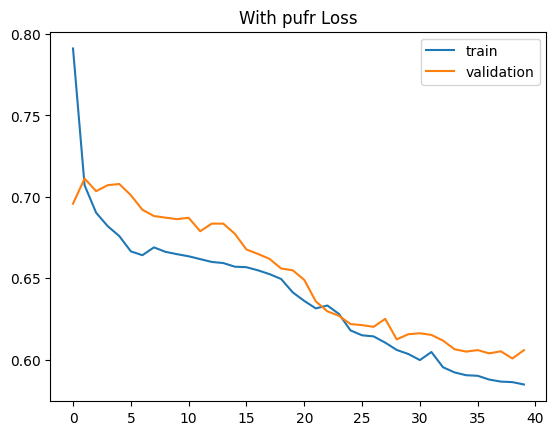


Training Baseline
Epoch: 1 	Train Loss: 0.7641 	Val Loss: 0.7049
Epoch: 2 	Train Loss: 0.6984 	Val Loss: 0.7083
Epoch: 3 	Train Loss: 0.6853 	Val Loss: 0.6928
Epoch: 4 	Train Loss: 0.675 	Val Loss: 0.6947
Epoch: 5 	Train Loss: 0.6704 	Val Loss: 0.69
Epoch: 6 	Train Loss: 0.6677 	Val Loss: 0.6953
Epoch: 7 	Train Loss: 0.666 	Val Loss: 0.6917
Epoch: 8 	Train Loss: 0.6636 	Val Loss: 0.6821
Epoch: 9 	Train Loss: 0.6624 	Val Loss: 0.6789
Epoch: 10 	Train Loss: 0.6607 	Val Loss: 0.6739
Epoch: 11 	Train Loss: 0.6592 	Val Loss: 0.6688
Epoch: 12 	Train Loss: 0.6576 	Val Loss: 0.6664
Epoch: 13 	Train Loss: 0.6566 	Val Loss: 0.6605
Epoch: 14 	Train Loss: 0.6554 	Val Loss: 0.6608
Epoch: 15 	Train Loss: 0.6535 	Val Loss: 0.6569
Epoch: 16 	Train Loss: 0.6526 	Val Loss: 0.656
Epoch: 17 	Train Loss: 0.6519 	Val Loss: 0.6554
Epoch: 18 	Train Loss: 0.6519 	Val Loss: 0.6535
Epoch: 19 	Train Loss: 0.6497 	Val Loss: 0.65
Epoch: 20 	Train Loss: 0.6475 	Val Loss: 0.6502
Epoch: 21 	Train Loss: 0.6488 	Val Lo

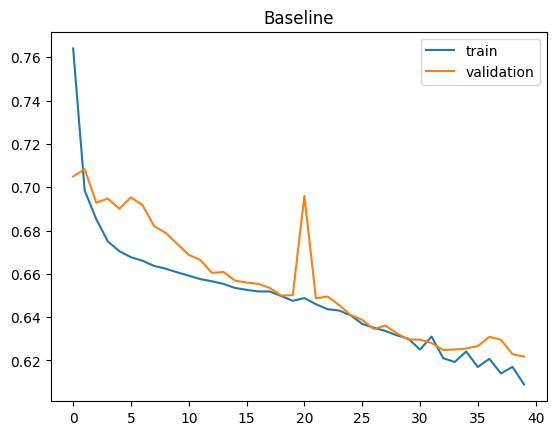

In [14]:
# Use BinaryCrossEntropy for binary classification
loss_fn = nn.BCELoss()

Epochs = 40

# Train model with pt,eta,phi,m,pufr
print("Training with PUFR")
PUFR = Model(5,32,1).to(device)
optimizer_pufr = optim.Adam(PUFR.parameters(), lr=0.0001)
data = [X_train_pufr, y_train, X_val_pufr, y_val]
PUFR_history = train(PUFR, optimizer_pufr, data, epochs=Epochs)
plt.plot(PUFR_history['train_loss'],label='train')
plt.plot(PUFR_history['test_loss'],label='validation')
plt.title("With pufr Loss")
plt.legend()
plt.show()
print()


# Train model with pt,eta,phi,m
print("Training Baseline")
Baseline = Model(4,32,1).to(device)
optimizer_baseline = optim.Adam(Baseline.parameters(), lr=0.0001)
data = [X_train_baseline, y_train, X_val_baseline, y_val]
Baseline_history = train(Baseline, optimizer_baseline, data, epochs=Epochs)
plt.plot(Baseline_history['train_loss'],label='train')
plt.plot(Baseline_history['test_loss'],label='validation')
plt.title("Baseline")
plt.legend()
plt.show()
print()

Epoch: 1 	Train Loss: 0.5841 	Val Loss: 0.5972
Epoch: 2 	Train Loss: 0.5846 	Val Loss: 0.6079
Epoch: 3 	Train Loss: 0.5807 	Val Loss: 0.6051
Epoch: 4 	Train Loss: 0.581 	Val Loss: 0.5965
Epoch: 5 	Train Loss: 0.5785 	Val Loss: 0.6024
Epoch: 6 	Train Loss: 0.5786 	Val Loss: 0.5996
Epoch: 7 	Train Loss: 0.578 	Val Loss: 0.6003
Epoch: 8 	Train Loss: 0.5777 	Val Loss: 0.5991
Epoch: 9 	Train Loss: 0.5764 	Val Loss: 0.5914
Epoch: 10 	Train Loss: 0.5757 	Val Loss: 0.6143
Epoch: 11 	Train Loss: 0.5739 	Val Loss: 0.5957
Epoch: 12 	Train Loss: 0.5736 	Val Loss: 0.5911
Epoch: 13 	Train Loss: 0.5768 	Val Loss: 0.6006
Epoch: 14 	Train Loss: 0.573 	Val Loss: 0.6101
Epoch: 15 	Train Loss: 0.572 	Val Loss: 0.592
Epoch: 16 	Train Loss: 0.5712 	Val Loss: 0.5925
Epoch: 17 	Train Loss: 0.5702 	Val Loss: 0.6023
Epoch: 18 	Train Loss: 0.5697 	Val Loss: 0.6012
Epoch: 19 	Train Loss: 0.5701 	Val Loss: 0.5996
Epoch: 20 	Train Loss: 0.5676 	Val Loss: 0.5957


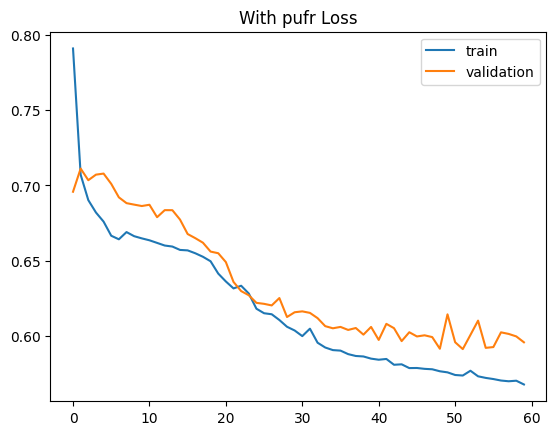

Epoch: 1 	Train Loss: 0.6161 	Val Loss: 0.6267
Epoch: 2 	Train Loss: 0.6078 	Val Loss: 0.6319
Epoch: 3 	Train Loss: 0.6055 	Val Loss: 0.6234
Epoch: 4 	Train Loss: 0.605 	Val Loss: 0.6226
Epoch: 5 	Train Loss: 0.6104 	Val Loss: 0.6193
Epoch: 6 	Train Loss: 0.6121 	Val Loss: 0.6194
Epoch: 7 	Train Loss: 0.6078 	Val Loss: 0.6235
Epoch: 8 	Train Loss: 0.6096 	Val Loss: 0.6238
Epoch: 9 	Train Loss: 0.6003 	Val Loss: 0.6246
Epoch: 10 	Train Loss: 0.5999 	Val Loss: 0.6166
Epoch: 11 	Train Loss: 0.599 	Val Loss: 0.6201
Epoch: 12 	Train Loss: 0.5965 	Val Loss: 0.6261
Epoch: 13 	Train Loss: 0.5965 	Val Loss: 0.6304
Epoch: 14 	Train Loss: 0.5967 	Val Loss: 0.6173
Epoch: 15 	Train Loss: 0.596 	Val Loss: 0.6189
Epoch: 16 	Train Loss: 0.5936 	Val Loss: 0.6387
Epoch: 17 	Train Loss: 0.5942 	Val Loss: 0.6209
Epoch: 18 	Train Loss: 0.5917 	Val Loss: 0.6365
Epoch: 19 	Train Loss: 0.5893 	Val Loss: 0.6226
Epoch: 20 	Train Loss: 0.5907 	Val Loss: 0.6161


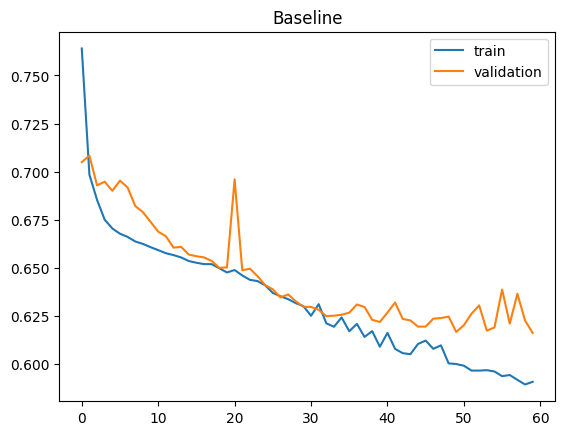

In [15]:
Epochs = 20

data = [X_train_pufr, y_train, X_val_pufr, y_val]
PUFR_history2 = train(PUFR, optimizer_pufr, data, epochs=Epochs)
PUFR_history['train_loss'] = np.concatenate([PUFR_history['train_loss'],PUFR_history2['train_loss']], axis=0)
PUFR_history['test_loss'] = np.concatenate([PUFR_history['test_loss'],PUFR_history2['test_loss']], axis=0)
plt.plot(PUFR_history['train_loss'],label='train')
plt.plot(PUFR_history['test_loss'],label='validation')
plt.title("With pufr Loss")
plt.legend()
plt.show()

data = [X_train_baseline, y_train, X_val_baseline, y_val]
Baseline_history2 = train(Baseline, optimizer_baseline, data, epochs=Epochs)
Baseline_history['train_loss'] = np.concatenate([Baseline_history['train_loss'],Baseline_history2['train_loss']], axis=0)
Baseline_history['test_loss'] = np.concatenate([Baseline_history['test_loss'],Baseline_history2['test_loss']], axis=0)
plt.plot(Baseline_history['train_loss'],label='train')
plt.plot(Baseline_history['test_loss'],label='validation')
plt.title("Baseline")
plt.legend()
plt.show()

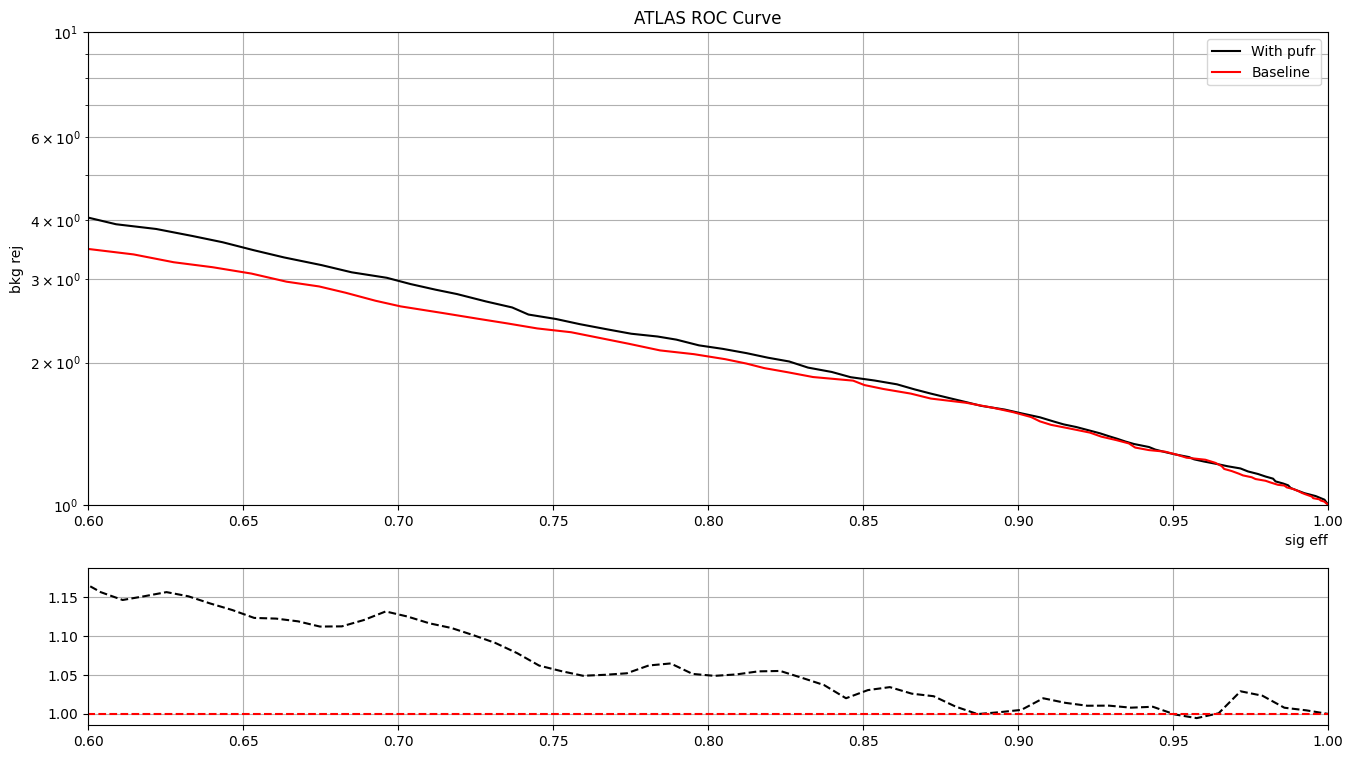

With pufr	 Binary Accuracy:  0.6776 	F1 Score:  0.6491075315629081 	AUC:  0.7420675147549209

Baseline	 Binary Accuracy:  0.6572 	F1 Score:  0.6252732837778749 	AUC:  0.7259760378450543



In [16]:
def ATLAS_roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    bkg_eff = []
    
    thresholds = np.linspace(0,0.7,100)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(1-((y_pred[bkg] < threshold).sum() / y_true[bkg].shape[0]))

        #print("Theshold: ", threshold)
        #print("Signal Efficiency: ", sig_eff[-1])
        #print("Background Efficiency: ", bkg_eff[-1],"\n")
        
    bkg_rej = [1/x for x in bkg_eff]
    return np.array(sig_eff), np.array(bkg_rej), thresholds

def get_predictions(model, data):
    X_test, y_test = data
    model.to(device)
    model.eval()
    
    label_pred = []

    num_test = X_test.size(0)
    for event in range(num_test):
        l_pred = model(X_test[event].to(device))
        label_pred.append(l_pred.detach().cpu().numpy())
    label_pred = np.array(label_pred)
    return label_pred

def get_metrics(y_true, y_pred, threshold):
    y_Pred = y_pred > threshold
    x,y, thresholds = ATLAS_roc(y_true, y_pred)
    AUC = roc_auc_score(y_true, y_pred)
    BA = accuracy_score(y_true, y_Pred)
    f1 = f1_score(y_true, y_Pred)
    return x,y,thresholds,AUC,BA,f1

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]})

pufr_pred = get_predictions(PUFR, [X_test_pufr, y_test])
baseline_pred = get_predictions(Baseline, [X_test_baseline, y_test])

x1,y1,th1,AUC1,BA1,f11 = get_metrics(y_test, pufr_pred, 0.5)
x2,y2,th2,AUC2,BA2,f12 = get_metrics(y_test, baseline_pred, 0.5)

ax1.set_title("ATLAS ROC Curve")
ax1.set_xlabel("sig eff",loc='right')
ax1.set_ylabel("bkg rej")

ax1.plot(x1,y1, label="With pufr",color='k')
AUC = "All Jets ROC AUC: " + str(round(AUC1,4))
#ax1.text(0.71,8,AUC)

ax1.plot(x2,y2, label="Baseline",color='r')
AUC = "Leading ROC AUC: " + str(round(AUC2,4))
#ax1.text(0.71,4,AUC)

# Plot ratio plot
x = 1-np.flip(th1)
ratio1 = np.interp(x,np.flip(x1),np.flip(y1))/np.interp(x,np.flip(x2),np.flip(y2))
ratio2 = np.interp(x,np.flip(x2),np.flip(y2))/np.interp(x,np.flip(x2),np.flip(y2))

ax2.plot(x,ratio1,linestyle='--',color='k')
ax2.plot(x,ratio2,linestyle='--',color='r')

# General Plot Settings
ax1.legend()
ax1.set_yscale('log')
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_ylim(1,10)
ax1.set_xlim(0.6,1)
ax2.set_xlim(0.6,1)
plt.show()

print("With pufr\t","Binary Accuracy: ", BA1, "\tF1 Score: ", f11, "\tAUC: ", AUC1)
print("")
print("Baseline\t","Binary Accuracy: ", BA2, "\tF1 Score: ", f12, "\tAUC: ", AUC2)
print("")

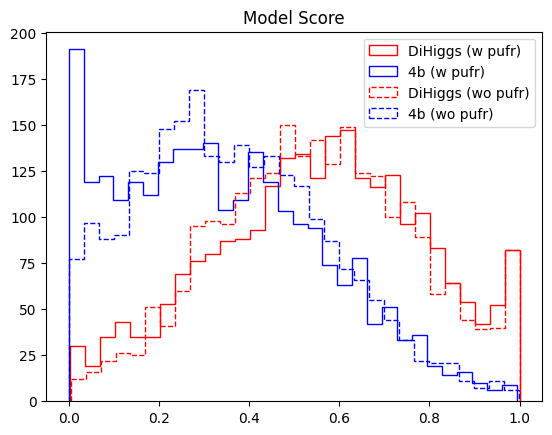

In [37]:
plt.title("Model Score")
plt.hist(pufr_pred[mask],color='r',histtype='step',label='DiHiggs (w pufr)',bins=30)
plt.hist(pufr_pred[~mask],color='b',histtype='step',label='4b (w pufr)',bins=30)
plt.hist(baseline_pred[mask],color='r',histtype='step',label='DiHiggs (wo pufr)',bins=30,linestyle='--')
plt.hist(baseline_pred[~mask],color='b',histtype='step',label='4b (wo pufr)',bins=30,linestyle='--')
plt.legend()
plt.show()